In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except: #Throws if already set
    pass

import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='
# os.environ['JAX_PLATFORMS'] = 'cpu'

In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from train import load_last_state
from data import TAPDataset, TAPDataLoader

In [3]:
import data
reload(data)
from data import TAPDataset, TAPDataLoader

run_dir = Path("../runs/hybrid_feature_ablation/trim_20240719_200421")
cfg, model, trainer_state, opt_state, _ = load_last_state(run_dir)
cfg['quiet'] = False

train_dataset = TAPDataset(cfg)

plt.plot(trainer_state['loss_list'])

Loading model state from ../runs/hybrid_feature_ablation/trim_20240719_200421/epoch030


2024-07-23 12:16:16.910359: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Model contains 166,403 parameters, using 650.01KB memory.
Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']
Data Hash: 45b36d6a16586af4d53563f1af62b9dd6c76f4b115c84b14e7c783d0767b4331
Using cached basin dataset file.


Updating Indices:   0%|          | 0/588 [00:00<?, ?it/s]

In [4]:
import data
reload(data)
from data import TAPDataset, TAPDataLoader

cfg['data_dir'] = Path("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/Predictions/Missouri")
cfg['train_basin_file'] = "metadata/site_lists/all_sites.txt"
cfg['test_basin_file'] = "metadata/site_lists/all_sites.txt"
cfg['log_norm_cols'] = []
cfg['target_weights'] = []
cfg['data_subset'] = 'predict'
cfg['features']['static'] = train_dataset.static_features

fig_dir = run_dir / "figures" / "Missouri"
fig_dir.mkdir(parents=True, exist_ok=True)

dataset = TAPDataset(cfg,
                     dynamic_scale = train_dataset.scale,
                     static_scale = train_dataset.attributes_scale,
                     inference_mode = True)

Data Hash: 21e296244c3e67057244b9ca6b76f5fcf047f8bc156aa4ebf9bf718e68e5988a
Using cached basin dataset file.


Updating Indices:   0%|          | 0/283 [00:00<?, ?it/s]

In [53]:
import evaluate
reload(evaluate)
from evaluate import model_iterate

cfg['num_workers'] = 0
cfg['batch_size'] = 64

dataloader_kwargs = dataset.date_batching('predict_all',['2020-01-01','2021-01-01'])
cfg.update(dataloader_kwargs)
dataloader = TAPDataLoader(cfg, dataset)

data_tuple_list = []
for basin, date, y_pred, dt in model_iterate(model, dataloader, True, False, True):
    data_tuple_list.append((basin, date, y_pred))

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


  0%|          | 0/366 [00:00<?, ?it/s]

(283, 3)

In [12]:
import geopandas as gpd

datasets = Path("/work/pi_kandread_umass_edu/Datasets/")
save_dir = Path("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/Predictions/Missouri")
metadata_dir = save_dir / "metadata"
preprocess_dir = save_dir / "preprocess"

print("reading NHD")
nhd_file = datasets / "River_SR" / "nhd_grwl_full_20191002.shp"
nhd_cols = {'COMID':'nhd_comid',
            'GNIS_NA': 'name',
            'REACHCODE':'nhd_reachcode',
            'ID':'riversr_id',
            'TotDASqKM':'nhd_area',
            'geometry':'geometry'}
nhd = gpd.read_file(nhd_file, engine="pyogrio", use_arrow=True)
nhd = nhd[list(nhd_cols.keys())].rename(columns=nhd_cols)
nhd = nhd.set_index('nhd_comid')

print("reading NHD reach polygons")
nhd_reach_polygons = gpd.read_file(metadata_dir / 'nhd_reach_polygons.shp', engine="pyogrio", use_arrow=True)

print("reading matchups")
matchups = pd.read_csv(preprocess_dir / 'predict_missouri_matchups.csv',index_col='nhd_comid')

print("reading hydroatlas")
gdb_path = datasets / "HydroATLAS" / "BasinATLAS_v10.gdb"
layer_name = "BasinATLAS_v10_lev12"

hydroatlas = gpd.read_file(gdb_path, layer=layer_name, columns=['HYBAS_ID','DIST_MAIN'], engine="pyogrio", use_arrow=True)

print("Done!")

reading NHD


Exception ignored in: <function tqdm.__del__ at 0x7f0f266b8430>
Traceback (most recent call last):
  File "/home/tlanghorst_umass_edu/.conda/envs/tss-ml/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/tlanghorst_umass_edu/.conda/envs/tss-ml/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


reading NHD reach polygons
reading matchups
reading hydroatlas


/home/tlanghorst_umass_edu/.conda/envs/tss-ml/lib/python3.10/site-packages/pyogrio/raw.py:329: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  table = reader.read_all()


Done!


In [19]:
geom_matchups = matchups.join(nhd_reach_polygons.set_index('nhd_comid')['geom_index'])
geom_matchups = geom_matchups.merge(hydroatlas[['HYBAS_ID','DIST_MAIN']], left_on='hybas_id', right_on='HYBAS_ID', how='left')
geom_matchups.index = matchups.index

def get_geom_centerline(geom_idx):
    in_geom = geom_matchups['geom_index']==geom_idx
    centerline = nhd.loc[in_geom[in_geom].index].geometry.union_all()#.line_merge()
    return centerline

def get_dist_out(geom_idx):
    in_geom = geom_matchups['geom_index']==geom_idx
    dist_out = geom_matchups[in_geom]['DIST_MAIN'].mean()
    return dist_out
    
geom_ids = nhd_reach_polygons.geom_index.unique()
centerlines = [get_geom_centerline(idx) for idx in geom_ids]
dist_out = [get_dist_out(idx) for idx in geom_ids]
centerline_gdf = gpd.GeoDataFrame(index=geom_ids, data={'dist_out':dist_out}, geometry=centerlines)

#initialize the prediciton columns
centerline_gdf[dataset.target] = np.NaN

/tmp/ipykernel_1254172/1710614457.py:67: UserWarning: frames=<function profile_animation.<locals>.frames at 0x7f0adf0c4430> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, frames=frames,


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

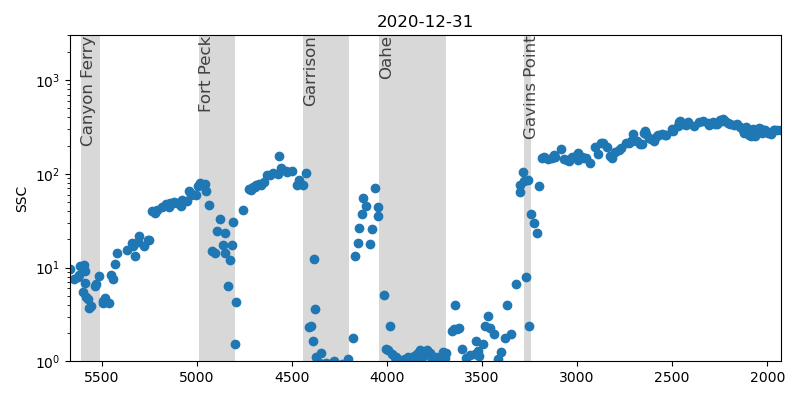

In [56]:
import matplotlib.patches as patches
from tqdm.auto import tqdm

x = centerline_gdf['dist_out']
xlim = [x.min(), x.max()]
dams = {
    'Gavins Point': [3240, 3280],
    'Oahe': [3690, 4040],
    'Garrison': [4200, 4440],
    'Fort Peck': [4800, 4990],
    'Canyon Ferry': [5510, 5610]}
ylim = [1, 3000]

y_pred = [tup[2] for tup in data_tuple_list]
y_pred_avg = np.mean(y_pred, axis=0)

def profile_animation(cfg, model, dataset):
    from data import TAPDataLoader
    from evaluate import model_iterate
    import matplotlib.animation as animation
    
    # Create an empty plot
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    fig.set_tight_layout(True)
    
    for name, dam_x in dams.items():
        rect = patches.Rectangle((dam_x[0], ylim[0]), dam_x[1]-dam_x[0], ylim[1]-ylim[0],
                             facecolor='gray', alpha=0.3)
        ax1.add_patch(rect)  
        
        # Add vertically oriented text
        ax1.text(dam_x[1], ylim[1], name, rotation=90, va='top', ha='left', 
             fontsize=12, color='black', alpha=0.7) 
    
    # Initialize scatter plot
    scatter1, = ax1.semilogy([], [], 'o')
    
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_ylabel('SSC')
    ax1.invert_xaxis()
    
    # Data iterator wrapper for frames
    def frames():
        for data in tqdm(data_tuple_list):
            yield data
            
    # Updates the plot based on the data passed by frames()
    def update(frame):
        basins, dates, batch = frame
        basins = [float(b) for b in basins]
        
        for i, t in enumerate(dataset.target):
            centerline_gdf.loc[basins, t] = batch[:,i]# / y_pred_avg[:,i]
        
        # Update scatter plots
        scatter1.set_data(x, centerline_gdf['ssc'])
        
        date = pd.Timestamp(dates[0])
        plt.title(date.strftime('%Y-%m-%d'))

        return scatter1

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=frames, 
                                interval=1000/10, repeat=True)
    
    return ani

ani = profile_animation(cfg, model, dataset)
ani.save('missouri_ssc_2020_animation.mp4', writer='ffmpeg', dpi=300)


In [31]:
#initialize the prediciton columns
centerline_gdf[dataset.target] = np.NaN

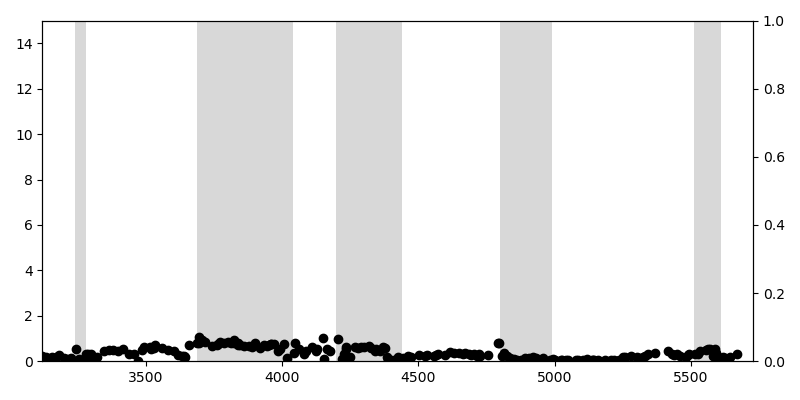

In [46]:
import matplotlib.patches as patches

plt.close('all')
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
fig.set_tight_layout(True)
ax2 = ax1.twinx()

dams = {
    'Gavins Point': [3240, 3280],
    'Oahe': [3690, 4040],
    'Garrison': [4200, 4440],
    'Fort Peck': [4800, 4990],
    'Canyon Ferry': [5510, 5610]}
ylim1 = [0, 15]

ax1.set_ylim(ylim1)

for name, dam_x in dams.items():
    rect = patches.Rectangle((dam_x[0], ylim1[0]), dam_x[1]-dam_x[0], ylim1[1]-ylim1[0],
                         facecolor='gray', alpha=0.3)
    ax1.add_patch(rect)  

                  
x = centerline_gdf['dist_out']
# Initialize scatter plots
scatter1, = ax1.plot([], [], 'o', c='black', label='USGS Q')
# scatter2, = ax2.semilogy([], [], 'o', c='red', label='SSC')


# Update plot
basins, dates, batch = data_tuple_list[0]
basins = [float(b) for b in basins]

for i, t in enumerate(dataset.target):
    centerline_gdf.loc[basins, t] = batch[:,i] / y_pred_avg[:,i]

scatter1.set_data(x, centerline_gdf['flux'])
# scatter1.set_data(x, centerline_gdf['usgs_q'])
# scatter2.set_data(x, centerline_gdf['ssc'])

In [35]:
centerline_gdf['flux']

0.0          52.764320
1.0          58.973522
2.0          75.676460
3.0          19.166710
4.0          35.876133
             ...      
278.0    149582.968750
279.0    121946.890625
280.0    127192.265625
281.0    129969.484375
282.0    116618.609375
Name: flux, Length: 283, dtype: float64